# Single view metrology

In [2]:
import cv2
import numpy as np

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "."

def plot_img(img_name):
    image_path = f"{data_dir}/{img_name}"
    plt.imshow(cv2.imread(image_path)[:, :, ::-1])
    plt.axis("off")

(-0.5, 959.5, 1279.5, -0.5)

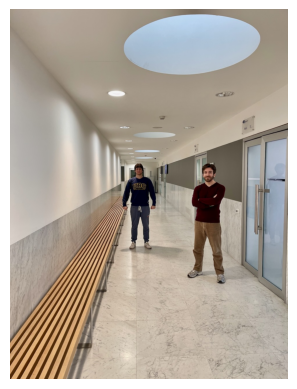

In [4]:
img = cv2.imread(f"{data_dir}/draft.jpeg")[:, :, ::-1]

plt.imshow(img)
plt.axis('off')

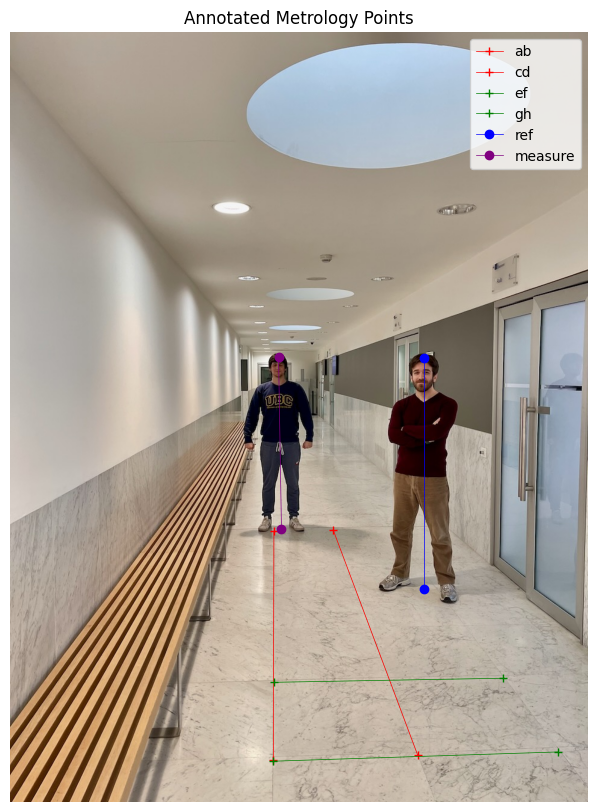

In [5]:
img = cv2.imread("draft.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load the annotations from the .npy file
annotations = np.load("simple_metrology_annotations.npy", allow_pickle=True).item()

# Get the lines from annotations
lines = annotations['lines']

# Plot the image and the lines
plt.figure(figsize=(10, 10))
plt.imshow(img)

# Define line labels for different line types
parallel1_labels = ["ab", "cd"]
parallel2_labels = ["ef", "gh"]

# Plot each line with appropriate label
parallel1_count = 0
parallel2_count = 0

for i, ((x1, y1), (x2, y2), line_type) in enumerate(lines):
    if line_type == 'parallel_1':
        label = parallel1_labels[parallel1_count]
        style = {"marker": "+", "linewidth": 0.5, "color": "red"}
        parallel1_count += 1
    elif line_type == 'parallel_2':
        label = parallel2_labels[parallel2_count]
        style = {"marker": "+", "linewidth": 0.5, "color": "green"}
        parallel2_count += 1
    elif line_type == 'reference':
        label = "ref"
        style = {"marker": "o", "linewidth": 0.5, "color": "blue"}
    elif line_type == 'measure':
        label = "measure"
        style = {"marker": "o", "linewidth": 0.5, "color": "purple"}
    
    plt.plot([x1, x2], [y1, y2], marker=style["marker"], label=label,
             linewidth=style["linewidth"], color=style["color"])

plt.legend()
plt.axis('off')
plt.title("Annotated Metrology Points")
plt.show()

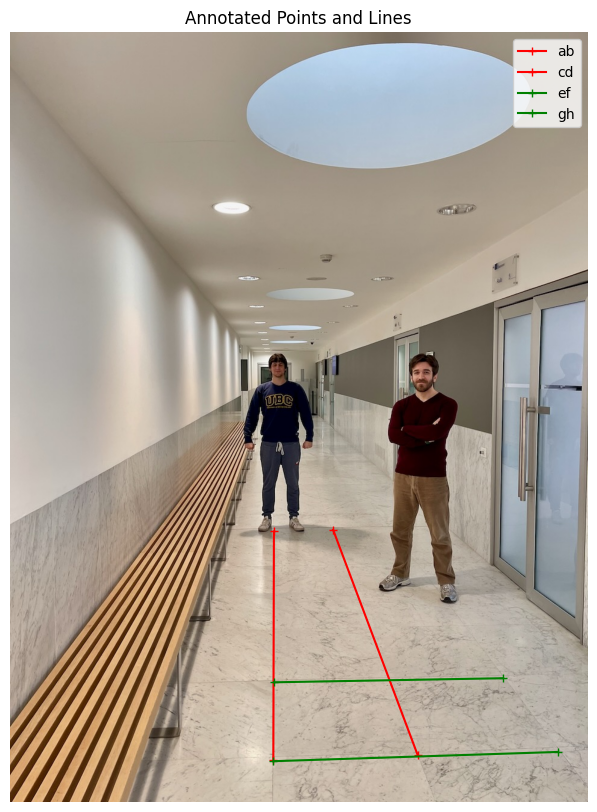

In [6]:
# Extract points from lines by type
parallel_lines_1 = [line for line in lines if line[2] == 'parallel_1']
parallel_lines_2 = [line for line in lines if line[2] == 'parallel_2']
reference_lines = [line for line in lines if line[2] == 'reference']
measure_lines = [line for line in lines if line[2] == 'measure']

# Create point labels for each set of parallel lines
point_labels_1 = ['a', 'b', 'c', 'd']  # For parallel_1 lines
point_labels_2 = ['e', 'f', 'g', 'h']  # For parallel_2 lines
points = {}

# Initialize points dictionary with points from parallel_1 lines
point_index = 0
for i, ((x1, y1), (x2, y2), _) in enumerate(parallel_lines_1):
    # First endpoint
    points[point_labels_1[point_index]] = np.array([x1, y1, 1])
    point_index += 1
    
    # Second endpoint
    points[point_labels_1[point_index]] = np.array([x2, y2, 1])
    point_index += 1
    
    # Stop if we've used all available labels
    if point_index >= len(point_labels_1):
        break

# Initialize points dictionary with points from parallel_2 lines
point_index = 0
for i, ((x1, y1), (x2, y2), _) in enumerate(parallel_lines_2):
    # First endpoint
    points[point_labels_2[point_index]] = np.array([x1, y1, 1])
    point_index += 1
    
    # Second endpoint
    points[point_labels_2[point_index]] = np.array([x2, y2, 1])
    point_index += 1
    
    # Stop if we've used all available labels
    if point_index >= len(point_labels_2):
        break

# Now we can access points as individual variables
a = points.get('a')  # First point of first parallel_1 line
b = points.get('b')  # Second point of first parallel_1 line
c = points.get('c')  # First point of second parallel_1 line
d = points.get('d')  # Second point of second parallel_1 line
e = points.get('e')  # First point of first parallel_2 line
f = points.get('f')  # Second point of first parallel_2 line
g = points.get('g')  # First point of second parallel_2 line
h = points.get('h')  # Second point of second parallel_2 line

# Visualize the points and lines
plt.figure(figsize=(10,10))
plt.imshow(img)

# Plot parallel_1 lines in red
plt.plot([a[0], b[0]], [a[1], b[1]], marker='+', color='red', label='ab')
# a[0] is the x coordinate of point a
# a[1] is the y coordinate of point a
# plt.plot connects the points a and b with a red line, and the marker is a red plus at point a

# and so on for the other parallel lines
plt.plot([c[0], d[0]], [c[1], d[1]], marker='+', color='red', label='cd')

# Plot parallel_2 lines in green
plt.plot([e[0], f[0]], [e[1], f[1]], marker='+', color='green', label='ef')
plt.plot([g[0], h[0]], [g[1], h[1]], marker='+', color='green', label='gh')

plt.legend()
plt.axis('off')
plt.title("Annotated Points and Lines")
plt.show()

In [7]:
# Calculate vanishing points
# Compute lines in homogeneous coordinates for parallel_1
lab = np.cross(a, b)  # Line through points a and b
lcd = np.cross(c, d)  # Line through points c and d

# Normalize the lines
lab = lab / lab[-1]
lcd = lcd / lcd[-1]

# Stack parallel_1 lines and compute vanishing point using SVD
parallel_lines1 = np.vstack([lab, lcd])
_, _, vt = np.linalg.svd(parallel_lines1)
vp1 = vt[-1]  # This is our first vanishing point
vp1 = vp1 / vp1[-1]  # Normalize the vanishing point

print("Vanishing point 1 (from parallel_1 lines):")
print(vp1)

# Compute lines in homogeneous coordinates for parallel_2
lef = np.cross(e, f)  # Line through points e and f
lgh = np.cross(g, h)  # Line through points g and h

# Normalize the lines
lef = lef / lef[-1]
lgh = lgh / lgh[-1]

# Stack parallel_2 lines and compute vanishing point using SVD
parallel_lines2 = np.vstack([lef, lgh])
_, _, vt = np.linalg.svd(parallel_lines2)
vp2 = vt[-1]  # This is our second vanishing point
vp2 = vp2 / vp2[-1]  # Normalize the vanishing point

print("Vanishing point 2 (from parallel_2 lines):")
print(vp2)

# Compute horizon line from the two vanishing points
horizon = np.cross(vp1, vp2)
horizon = horizon / horizon[-1]  # Normalize the horizon line

print("Horizon line:")
print(horizon)

Vanishing point 1 (from parallel_1 lines):
[438.88834531 566.53562106   1.        ]
Vanishing point 2 (from parallel_2 lines):
[9.28689206e+03 9.23317869e+02 1.00000000e+00]
Horizon line:
[ 7.34706148e-05 -1.82203088e-03  1.00000000e+00]


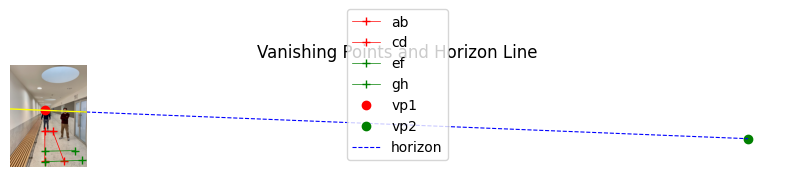

In [8]:
# Visualize vanishing points and horizon line
plt.figure(figsize=(10, 10))
plt.imshow(img)

# Plot the original lines
plt.plot([a[0], b[0]], [a[1], b[1]], marker='+', color='red', linewidth=0.5, label='ab')
plt.plot([c[0], d[0]], [c[1], d[1]], marker='+', color='red', linewidth=0.5, label='cd')
plt.plot([e[0], f[0]], [e[1], f[1]], marker='+', color='green', linewidth=0.5, label='ef')
plt.plot([g[0], h[0]], [g[1], h[1]], marker='+', color='green', linewidth=0.5, label='gh')

# Plot vanishing points
plt.plot(vp1[0], vp1[1], "o", color='red', label="vp1")
plt.plot(vp2[0], vp2[1], "o", color='green', label="vp2")

# Draw a line connecting the vanishing points (the horizon line)
plt.plot([vp1[0], vp2[0]], [vp1[1], vp2[1]], '--', color='blue', 
         label="horizon", linewidth=0.8)

# Draw the full horizon line across the image
if horizon[1] != 0:  # Avoid division by zero
    x_vals = np.array([0, img.shape[1]])
    y_vals = (-horizon[0] * x_vals - horizon[2]) / horizon[1]
    plt.plot(x_vals, y_vals, '-', color='yellow', linewidth=1)

plt.legend()
plt.axis('off')
plt.title("Vanishing Points and Horizon Line")
plt.show()

In [9]:
# Build the rectifying homography for the floor plane
# Important: normalize the horizon line coefficients to regularize the homography
horizon = horizon/np.linalg.norm(horizon)

H = np.hstack([np.eye(2), np.zeros((2, 1))])
H = np.vstack([H, horizon])
H = H/H[-1, -1]

# We can check that the horizon is now mapped to the canonical line at infinity
print(f"H^(-T)@horizon: {np.linalg.inv(H).T@horizon.reshape((-1,1))}")

H^(-T)@horizon: [[-5.93487602e-21]
 [ 7.06685411e-22]
 [ 9.99998337e-01]]


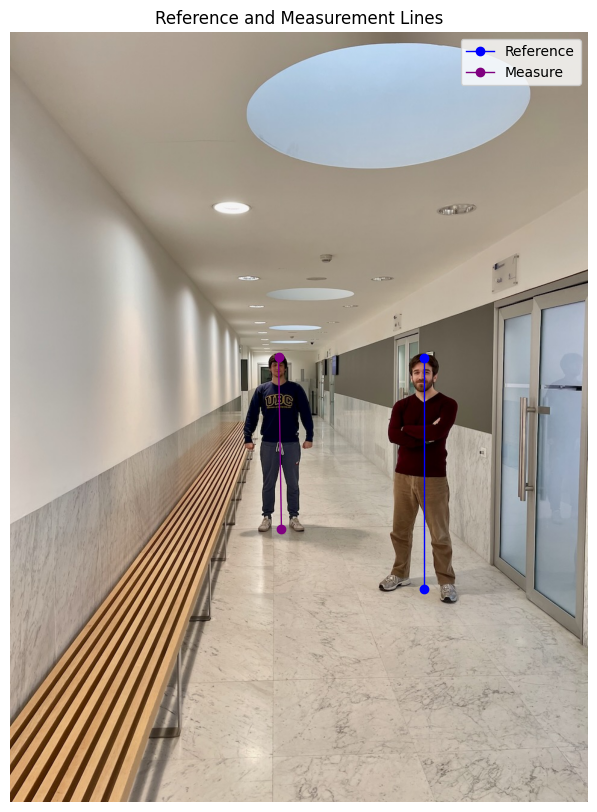

In [10]:
# Plot reference and measurement lines
# Extract reference and measurement points from your annotations
# For reference line (Line 4 in your annotations)
ref_line = reference_lines[0]
ref_top = np.array([ref_line[0][0], ref_line[0][1], 1])    # First point of reference line
ref_bottom = np.array([ref_line[1][0], ref_line[1][1], 1]) # Second point of reference line

# For measurement line
measure_line = measure_lines[0]
measure_top = np.array([measure_line[0][0], measure_line[0][1], 1])    # First point of measurement line
measure_bottom = np.array([measure_line[1][0], measure_line[1][1], 1]) # Second point of measurement line

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot([ref_top[0], ref_bottom[0]], [ref_top[1], ref_bottom[1]],
         marker="o", label="Reference", linewidth=1, color='blue')
plt.plot([measure_top[0], measure_bottom[0]], [measure_top[1], measure_bottom[1]],
         marker="o", label="Measure", linewidth=1, color='purple')
plt.legend()
plt.title("Reference and Measurement Lines")
plt.axis('off')
plt.show()

In [11]:
# Computing the metric measurements
# Calculate vertical vanishing point if not already available
# If we want to use SVD on all lines for vertical direction (optional)
all_lines = np.vstack([lab, lcd, lef, lgh])
_, _, vt = np.linalg.svd(all_lines)
v_vert = vt[-1]
v_vert = v_vert/v_vert[-1]

# Compute intersection points and distances
u = np.cross(np.cross(measure_bottom, ref_bottom), horizon)
u = u/u[-1]

l_measure = np.cross(measure_bottom, v_vert)
ref_top_tilde = np.cross(np.cross(ref_top, u), l_measure)
ref_top_tilde = ref_top_tilde/ref_top_tilde[-1]

dist_ref_top_tilde = np.linalg.norm(ref_top_tilde - ref_bottom)
dist_measure_top = np.linalg.norm(measure_top - measure_bottom)
dist_vert = np.linalg.norm(v_vert - ref_bottom)

# Compute 1d projective transformation mapping the vanishing point to infinity
# (0,1) -> (0,1)
# (v_vert,0) -> (1,0)
H_1d = np.eye(2)
H_1d[-1] = [1, dist_vert]

# Compute the distance ratio
dist_ref_measure_ratio = dist_ref_top_tilde * (dist_vert - dist_measure_top)/(dist_measure_top*(dist_vert-dist_ref_top_tilde))

# Measured dist = ref_dist / dist_ref_measure_ratio
ref_dist = 175  # Your given reference distance
measured_dist = ref_dist / dist_ref_measure_ratio

print(f"Reference distance: {ref_dist} units")
print(f"Measured distance: {measured_dist:.2f} units")
print(f"Distance ratio: {dist_ref_measure_ratio:.4f}")

Reference distance: 175 units
Measured distance: 276.23 units
Distance ratio: 0.6335


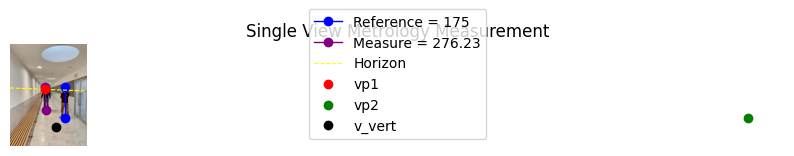

In [12]:
# Visualize the measurement results
plt.figure(figsize=(10, 10))
plt.imshow(img)

# Plot reference line
plt.plot([ref_top[0], ref_bottom[0]], [ref_top[1], ref_bottom[1]],
         marker="o", label=f"Reference = {ref_dist}", linewidth=1, color='blue')

# Plot measurement line 
plt.plot([measure_top[0], measure_bottom[0]], [measure_top[1], measure_bottom[1]],
         marker="o", label=f"Measure = {measured_dist:.2f}", linewidth=1, color='purple')

# Plot the horizon line
x_vals = np.array([0, img.shape[1]])
if horizon[1] != 0:  # Avoid division by zero
    y_vals = (-horizon[0] * x_vals - horizon[2]) / horizon[1]
    plt.plot(x_vals, y_vals, '--', color='yellow', linewidth=0.8, label="Horizon")

# Plot vanishing points
plt.plot(vp1[0], vp1[1], "o", color='red', label="vp1")
plt.plot(vp2[0], vp2[1], "o", color='green', label="vp2")
plt.plot(v_vert[0], v_vert[1], "o", color='black', label="v_vert")

plt.legend()
plt.title("Single View Metrology Measurement")
plt.axis('off')
plt.show()

Projected Ref = 394.57819589289977 
Projected Measure = 376.1267362265509 
Known original ref = 175
Estimated original measure = 166.81656392770498


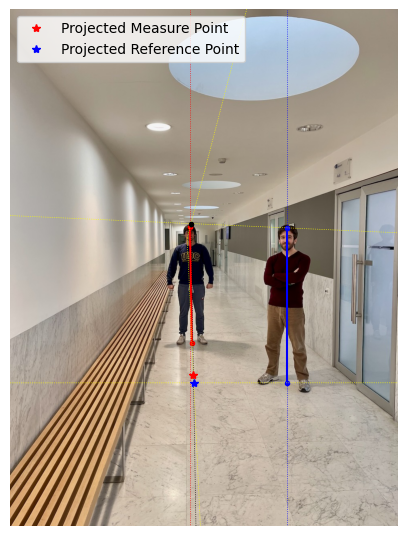

In [17]:
plt.figure(figsize=(5, 15))
plt.imshow(img)

# Reference Line
plt.plot(
    (ref_top[0], ref_bottom[0]),
    (ref_top[1], ref_bottom[1]),
    c='blue',
    marker = '.'
    )
plt.axvline(
    ref_top[0],
    c='blue',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Measurement Line
plt.plot(
    (measure_top[0], measure_bottom[0]),
    (measure_top[1], measure_bottom[1]),
    c='red',
    marker = '.'
    )
plt.axvline(
    measure_top[0],
    c='red',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Top Vanishing Point
ref_line = np.cross(ref_bottom, ref_top)
measure_line = np.cross(measure_bottom, measure_top)
vp3 = np.cross(ref_line, measure_line)
vp3 = vp3 / vp3[2]
plt.plot(
    vp3[0],
    vp3[1]
)

# Line through right vanishing point and top reference point
slope = (vp2[1] - ref_top[1]) / (vp2[0] - ref_top[0])
intercept = vp2[1] - slope * vp2[0]
x_vals = np.array([0, img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Line through right vanishing point and bottom refernce point
slope = (vp2[1] - ref_bottom[1]) / (vp2[0] - ref_bottom[0])
intercept = vp2[1] - slope * vp2[0]
x_vals = np.array([0, img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Line through back vanishing point and top reference point
# slope = (vp1[1] - ref_top[1]) / (vp1[0] - ref_top[0])
# intercept = vp1[1] - slope * vp1[0]
# x_vals = np.array([vp1[0], img.shape[1]])
# y_vals = slope * x_vals + intercept
# plt.plot(
#     x_vals,
#     y_vals,
#     c='yellow',
#     marker = '',
#     linestyle = ':',
#     linewidth= 0.5 
#     )

# Line through back vanishing point and bottom refernce point
# plt.plot(
#     vp1[0],
#     vp1[1],
#     c='yellow',
#     marker = 'o',
#     )
# slope = (vp1[1] - ref_bottom[1]) / (vp1[0] - ref_bottom[0])
# intercept = vp1[1] - slope * vp1[0]
# x_vals = np.array([vp1[0], img.shape[1]])
# y_vals = slope * x_vals + intercept
# plt.plot(
#     x_vals,
#     y_vals,
#     c='yellow',
#     marker = '',
#     linestyle = ':',
#     linewidth= 0.5 
#     )

# Line through back vanishing point and top measure point
slope = (vp1[1] - measure_top[1]) / (vp1[0] - measure_top[0])
intercept = vp1[1] - slope * vp1[0]
x_vals = np.array([vp1[0], img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Line through back vanishing point and bottom measure point
# plt.plot(
#     vp1[0],
#     vp1[1],
#     c='yellow',
#     marker = 'o',
#     )
slope = (vp1[1] - measure_bottom[1]) / (vp1[0] - measure_bottom[0])
intercept = vp1[1] - slope * vp1[0]
x_vals = np.array([vp1[0], img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Bottom Intersection
right_vp_to_ref_top = np.cross(vp2, ref_top)
back_vp_to_measure_top = np.cross(vp1, measure_top)
top_intersection = np.cross(right_vp_to_ref_top, back_vp_to_measure_top)
top_intersection = top_intersection / top_intersection[2]
plt.plot(
    top_intersection[0],
    top_intersection[1],
    c='k',
    marker = '.',
    )

# Vertical Line
bottom_vp_to_top_intersection = np.cross(vp3, top_intersection)
plt.plot(
    (vp3[0], top_intersection[0]),
    (vp3[1], top_intersection[1]),
    c='k',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Project the measurement and reference segment onto the vertical line
back_vp_to_measure_bottom = np.cross(vp1, measure_bottom)
measure_bottom_proj = np.cross(bottom_vp_to_top_intersection, back_vp_to_measure_bottom)
measure_bottom_proj = measure_bottom_proj / measure_bottom_proj[2]
plt.plot(
    measure_bottom_proj[0],
    measure_bottom_proj[1],
    c='red',
    marker = '*',
    label = 'Projected Measure Point',
    linewidth = 0,
    )

right_vp_to_ref_bottom = np.cross(vp2, ref_bottom)
ref_bottom_proj = np.cross(bottom_vp_to_top_intersection, right_vp_to_ref_bottom )
ref_bottom_proj = ref_bottom_proj / ref_bottom_proj[2]
plt.plot(
    ref_bottom_proj[0],
    ref_bottom_proj[1],
    c='blue',
    marker = '*',
    label = 'Projected Reference Point',
    linewidth = 0,
    )

# ref : measure = original_ref : original_measure
# -> original_measure = 
ref = np.linalg.norm(top_intersection[:2] - ref_bottom_proj[:2])
measure = np.linalg.norm(top_intersection[:2] - measure_bottom_proj[:2])
original_ref = 175
original_measure = measure * original_ref / ref
print(f'Projected Ref = {ref:} ')
print(f'Projected Measure = {measure:} ')
print(f"Known original ref = {original_ref}")
print(f"Estimated original measure = {original_measure}")

# Show everything
plt.legend()
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])
plt.axis('off')

plt.show()

Projected Ref = 394.57819589289977 
Projected Measure = 376.1267362265509 
Known original ref = 175
Estimated original measure = 166.81656392770498


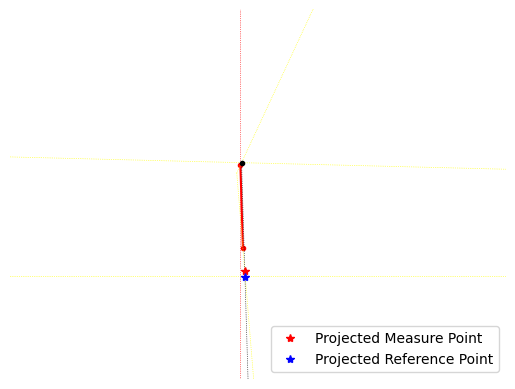

In [18]:

# Measurement Line
plt.plot(
    (measure_top[0], measure_bottom[0]),
    (measure_top[1], measure_bottom[1]),
    c='red',
    marker = '.'
    )
plt.axvline(
    measure_top[0],
    c='red',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Top Vanishing Point
ref_line = np.cross(ref_bottom, ref_top)
measure_line = np.cross(measure_bottom, measure_top)
vp3 = np.cross(ref_line, measure_line)
vp3 = vp3 / vp3[2]
plt.plot(
    vp3[0],
    vp3[1]
)

# Line through right vanishing point and top reference point
slope = (vp2[1] - ref_top[1]) / (vp2[0] - ref_top[0])
intercept = vp2[1] - slope * vp2[0]
x_vals = np.array([0, img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Line through right vanishing point and bottom refernce point
slope = (vp2[1] - ref_bottom[1]) / (vp2[0] - ref_bottom[0])
intercept = vp2[1] - slope * vp2[0]
x_vals = np.array([0, img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Line through back vanishing point and top reference point
# slope = (vp1[1] - ref_top[1]) / (vp1[0] - ref_top[0])
# intercept = vp1[1] - slope * vp1[0]
# x_vals = np.array([vp1[0], img.shape[1]])
# y_vals = slope * x_vals + intercept
# plt.plot(
#     x_vals,
#     y_vals,
#     c='yellow',
#     marker = '',
#     linestyle = ':',
#     linewidth= 0.5 
#     )

# Line through back vanishing point and bottom refernce point
# plt.plot(
#     vp1[0],
#     vp1[1],
#     c='yellow',
#     marker = 'o',
#     )
# slope = (vp1[1] - ref_bottom[1]) / (vp1[0] - ref_bottom[0])
# intercept = vp1[1] - slope * vp1[0]
# x_vals = np.array([vp1[0], img.shape[1]])
# y_vals = slope * x_vals + intercept
# plt.plot(
#     x_vals,
#     y_vals,
#     c='yellow',
#     marker = '',
#     linestyle = ':',
#     linewidth= 0.5 
#     )

# Line through back vanishing point and top measure point
slope = (vp1[1] - measure_top[1]) / (vp1[0] - measure_top[0])
intercept = vp1[1] - slope * vp1[0]
x_vals = np.array([vp1[0], img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Line through back vanishing point and bottom measure point
# plt.plot(
#     vp1[0],
#     vp1[1],
#     c='yellow',
#     marker = 'o',
#     )
slope = (vp1[1] - measure_bottom[1]) / (vp1[0] - measure_bottom[0])
intercept = vp1[1] - slope * vp1[0]
x_vals = np.array([vp1[0], img.shape[1]])
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals,
    y_vals,
    c='yellow',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Bottom Intersection
right_vp_to_ref_top = np.cross(vp2, ref_top)
back_vp_to_measure_top = np.cross(vp1, measure_top)
top_intersection = np.cross(right_vp_to_ref_top, back_vp_to_measure_top)
top_intersection = top_intersection / top_intersection[2]
plt.plot(
    top_intersection[0],
    top_intersection[1],
    c='k',
    marker = '.',
    )

# Vertical Line
bottom_vp_to_top_intersection = np.cross(vp3, top_intersection)
plt.plot(
    (vp3[0], top_intersection[0]),
    (vp3[1], top_intersection[1]),
    c='k',
    marker = '',
    linestyle = ':',
    linewidth= 0.5 
    )

# Project the measurement and reference segment onto the vertical line
back_vp_to_measure_bottom = np.cross(vp1, measure_bottom)
measure_bottom_proj = np.cross(bottom_vp_to_top_intersection, back_vp_to_measure_bottom)
measure_bottom_proj = measure_bottom_proj / measure_bottom_proj[2]
plt.plot(
    measure_bottom_proj[0],
    measure_bottom_proj[1],
    c='red',
    marker = '*',
    label = 'Projected Measure Point',
    linewidth = 0,
    )

right_vp_to_ref_bottom = np.cross(vp2, ref_bottom)
ref_bottom_proj = np.cross(bottom_vp_to_top_intersection, right_vp_to_ref_bottom )
ref_bottom_proj = ref_bottom_proj / ref_bottom_proj[2]
plt.plot(
    ref_bottom_proj[0],
    ref_bottom_proj[1],
    c='blue',
    marker = '*',
    label = 'Projected Reference Point',
    linewidth = 0,
    )

# ref : measure = original_ref : original_measure
# -> original_measure = 
ref = np.linalg.norm(top_intersection[:2] - ref_bottom_proj[:2])
measure = np.linalg.norm(top_intersection[:2] - measure_bottom_proj[:2])
original_ref = 175
original_measure = measure * original_ref / ref
print(f'Projected Ref = {ref:} ')
print(f'Projected Measure = {measure:} ')
print(f"Known original ref = {original_ref}")
print(f"Estimated original measure = {original_measure}")

# Show everything
plt.legend()
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])
plt.axis('off')

plt.show()